In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from trajectory import Trajectory

traj = Trajectory("../res/tristan_md_trajectory_N125_F500_L10.0.xyz")
traj

Trajectory information:
File path: "../res/tristan_md_trajectory_N125_F500_L10.0.xyz"
Number of atoms: 125, number of frames: 500
Box size: [10. 10. 10.], element(s): Ar

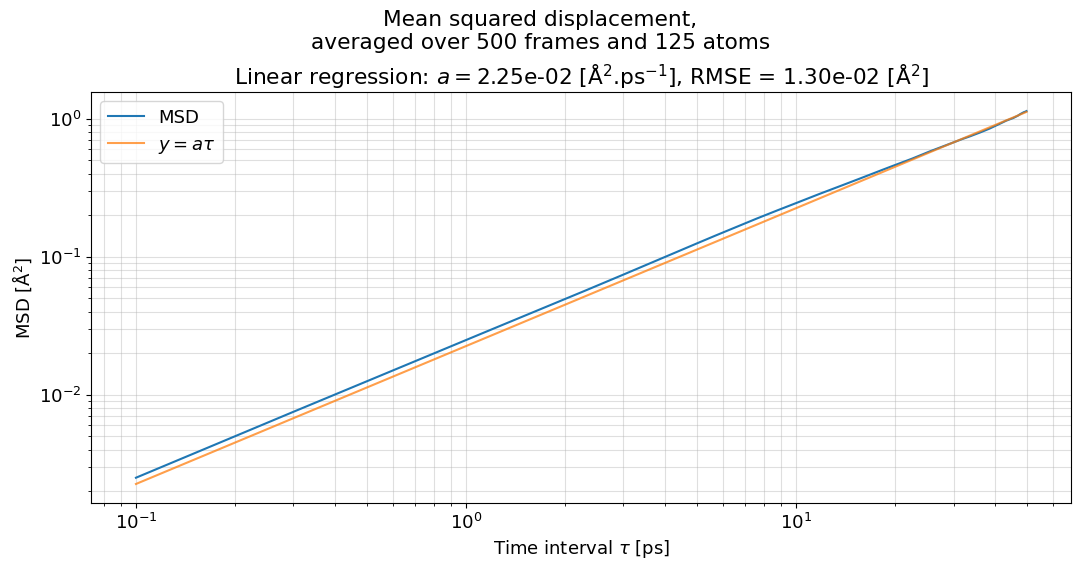

In [3]:
msd = traj.mean_squared_displacement()

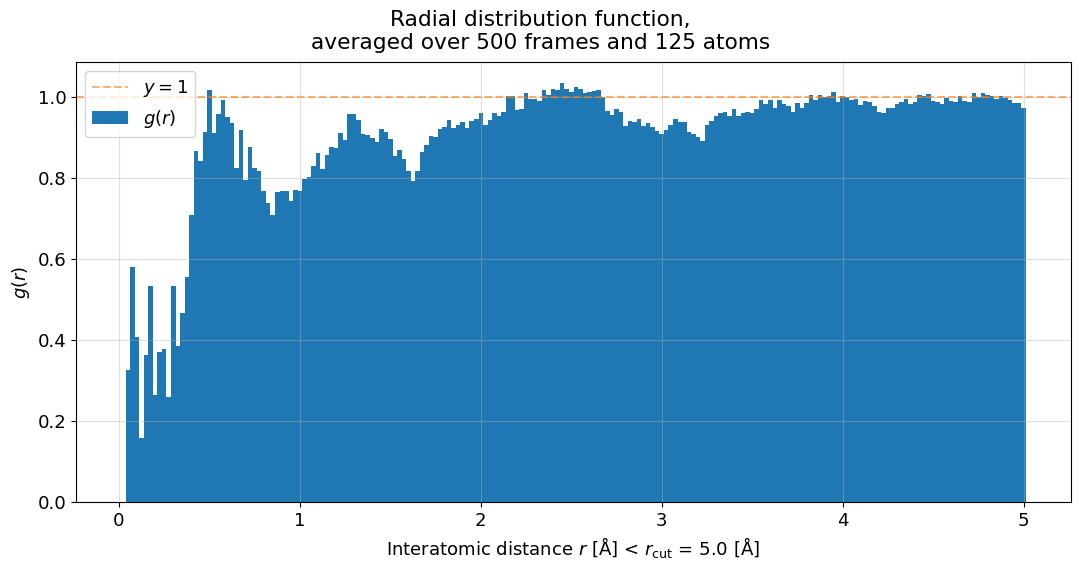

In [4]:
rdf = traj.radial_distribution_function()